## Anfangs-Randwertaufgaben

Wir gehen noch einen Schritt weiter und kombinieren die Anfangswertaufgaben mit den Randwertaufgaben. D.h. wir lösen instationäre Vorgänge.

Als Beispiel dient dieses Mal die zweidimensionale Diffusionsgleichung ([2. Fick'sches Gesetz](https://de.wikipedia.org/wiki/Diffusion)):

$$\frac{\partial c}{\partial t} = D \cdot \frac{\partial^2 c}{\partial x^2} + D \cdot \frac{\partial^2 c}{\partial y^2}$$

Darin ist $c$ die Konzentration (z.B. die Tintenkonzentration) und $D$ der [Diffusionskoeffizient](https://de.wikipedia.org/wiki/Diffusionskoeffizient) mit der Einheit $\text{m}^2/\text{s}$ (z.B. für Tinte in Wasser, $D \approx 1\cdot 10^{-9} \text{m}^2/\text{s}$).

> Die Gleichung für die instationäre Wärmeleitung ([Fourier-Gleichung](https://de.wikipedia.org/wiki/Wärmeleitung)) hat übrigens die gleiche Form. Nur steht dort statt der Konzentration die Temperatur $T$ und statt dem Diffusionskoeffizient $D$ die [Temperaturleitfähigkeit](https://de.wikipedia.org/wiki/Temperaturleitfähigkeit) (Wärmediffusivität) $a = \lambda/(\rho c_p)$.


### Räumliche Diskretisierung

Für die räumliche Diskretisierung verteilen wir die Punkte, an denen die Gleichung gelöst wird äquidistant auf dem Rechengebiet und nummerieren diese mit den beiden Laufvariablen $i$ und $j$ durch (siehe Abbildung).

![](ij-Gitter.png)


Wir betrachten zunächst die rechte Seite der Gleichung. Beide Terme werden mit dem Zentraldifferenzenverfahren diskretisiert. Die erste partielle Ableitung wird bei konstantem $y$, also konstantem $j$-Index gebildet:

$$D \cdot \frac{\partial^2 c}{\partial x^2} = D \cdot \frac{c_{i-1,j} - 2c_{i,j} + c_{i+1,j}}{\Delta h^2}$$

Bei der zweiten partiellen Ableitung bleibt $x$ konstant und damit der $i$-Index:

$$D \cdot \frac{\partial^2 c}{\partial y^2} = D \cdot \frac{c_{i,j-1} - 2c_{i,j} + c_{i,j+1}}{\Delta h^2}$$

### Zeitliche Diskretisierung

#### Explizit mit dem Euler-Vorwärts-Verfahren
Um die Sache nicht zu verkomplizieren, verwenden wir zunächst zur zeitlichen Diskretisierung ein einfaches explizites Euler-Verfahren, das wir bei den Anfangswertaufgaben bereits kennengelernt haben. In der folgenden Gleichung sind $i$ und $j$ die Indizes für die Ortsdiskretisierung und $k$ der Index für die zeitliche Diskretisierung.

$$c_{i,j}^{k+1} = c_{i,j}^k + \frac{\Delta t \cdot D}{\Delta h^2} \cdot \left[c_{i-1,j}^k - 2c_{i,j}^k + c_{i+1,j}^k + c_{i,j-1}^k - 2c_{i,j}^k + c_{i,j+1}^k\right]$$

Man sieht sofort, dass auf der rechten Seite der Gleichung nur bekannte Werte stehen. D.h. der Wert an einem Punkt zum neuen Zeitpunkt kann explizit durch die Werte benachbarter Punkte zum alten Zeitpunkt berechnet werden.

![](eulervorwaerts.png)

Die Implementierung in Python ist entsprechend einfach. In einem ersten Schritt legen wir die anfängliche Verteilung der Tintenkonzentration in unserem Rechengebiet so fest, dass im Zentrum die Konzentration 1 herrscht.

In [1]:
import numpy as np

# Konstanten
n_i = 101
n_j = 101
delta_h = 0.0001
breite = n_i * delta_h
hoehe = n_j * delta_h

# Variablen
c = np.zeros((n_i, n_j))         # Konzentration

x = np.linspace(0, breite, n_i)  # x-Koordinaten
y = np.linspace(0, hoehe, n_j)   # y-Koordinaten

c[int(0.4*n_i):int(0.6*n_i),int(0.4*n_j):int(0.6*n_j)] = 1.0

Eine Visualiesierung mit der Matplotlib ergibt:

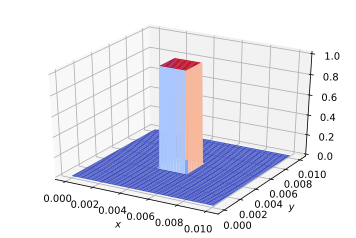

In [2]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D

%config InlineBackend.figure_format = 'svg'
%matplotlib inline

plt.figure(figsize=(6, 4))
ax = plt.gca(projection='3d')
X, Y = np.meshgrid(x, y)

ax.plot_surface(X, Y, c, cmap=cm.coolwarm, rstride=2, cstride=2, antialiased=True)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$');

Als nächstes verwenden wir die diskretisierte Gleichung, um jeweils die Konzentrationsverteilung zum nächsten Zeitschritt auszurechnen.

In [9]:
delta_t = 50        # Zeitschrittweite
D = 0.5e-9         # Diffusionsparameter in m^2/s

n_t = 1000          # Anzahl der Zeitschritte

D_num = delta_t * D / delta_h**2

print ("Diffusionszahl: ", D_num)
for k in range(n_t+1):
    c_alt = c.copy()
    for i in range(1,n_i-1):
        for j in range(1,n_j-1):
            c[i,j] = c_alt[i,j] + (D_num * 
                                   (c_alt[i-1,j] 
                                    - 4*c_alt[i,j] 
                                    + c_alt[i+1,j]
                                    + c_alt[i,j-1]
                                    + c_alt[i,j+1]))
    # Randbedingung: Gradient an der Wand = 0
    c[ 0,:] = c[ 1,:] # linker Rand
    c[-1,:] = c[-2,:] # rechter Rand
    c[:, 0] = c[:, 1] # unterer Rand
    c[:,-1] = c[:,-2] # oberer Rand

Diffusionszahl:  2.5


/Users/mstripf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in double_scalars
/Users/mstripf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars


/Users/mstripf/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
/Users/mstripf/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)
/Users/mstripf/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/Users/mstripf/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


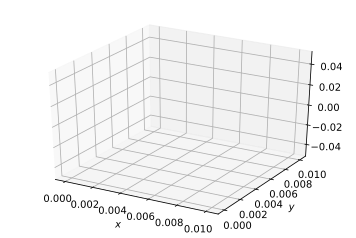

In [10]:
plt.figure(figsize=(6, 4))
ax = plt.gca(projection='3d')
X, Y = np.meshgrid(x, y)

#ax.set_zlim(0, 1)
ax.plot_surface(X, Y, c, cmap=cm.coolwarm, rstride=2, cstride=2, antialiased=True)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$');


[Hier](2_1-Potentialtheorie_Einfuehrung.ipynb) geht's weiter oder [hier](index.ipynb) zurück zur Übersicht.


---
###### Copyright (c) 2018, Florian Theobald und Matthias Stripf

Der folgende Python-Code darf ignoriert werden. Er dient nur dazu, die richtige Formatvorlage für die Jupyter-Notebooks zu laden.

In [5]:
from IPython.core.display import HTML
def css_styling():
    styles = open('TFDStyle.css', 'r').read()
    return HTML(styles)
css_styling()